<a href="https://colab.research.google.com/github/yusufbingol/sign_verification/blob/main/signature.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pathlib
# from sklearn.model_selection import train_test_split
# from sklearn.model_selection import StratifiedKFold
# from sklearn.model_selection import cross_val_score

from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate, Dropout,BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Lambda, Flatten, Dense
from keras.regularizers import l2
from keras.models import Sequential, Model

import itertools
from sklearn.utils import shuffle
import seaborn as sn

import tensorflow as tf
import pandas as pd
import glob
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import keras.backend as K
import random

In [2]:
img_h, img_w = 155,220

In [3]:
def get_all_path(current_person, sign_type):
  imgs = []
  for i in range(1, 25):
      img_path = f'/content/drive/MyDrive/Colab_Notebooks/signatures/{sign_type}_{current_person}_{i}.png'
      imgs.append(img_path)
  
  return imgs # Returns the path of the original images.

In [4]:
def thresholding(img):
  uintImage = tf.keras.preprocessing.image.img_to_array(img, dtype='uint8') # Gaussian uygulanabilmesi için uint formatına çevirilir
  withBlur = cv2.GaussianBlur(uintImage,(5,5),0)  # Gaussian blur uygulanır
  (thresh, withOtsu) = cv2.threshold(withBlur, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU) # otsu metoduyla eşikleme yapılarak görüntüdeki gürültüler azaltılır ve binarization uygulanır
  bilinear_img = cv2.resize(withOtsu,(img_w,img_h), interpolation = cv2.INTER_LINEAR)
  return bilinear_img

In [5]:
def crop(img,tol=0):
    # img is 2D image data
    # tol  is tolerance
    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]

In [6]:
cv_originals = []
cv_forgeries = []
for i in range(1,56):
  cv_originals.append(get_all_path(i,'full_org/original'))
  cv_forgeries.append(get_all_path(i,'full_forg/forgeries'))

In [7]:
img = cv2.imread(cv_originals[5][2],0)
imgTresh=thresholding(img)
imgThreshCrop = crop(imgTresh)



(-0.5, 201.5, 65.5, -0.5)

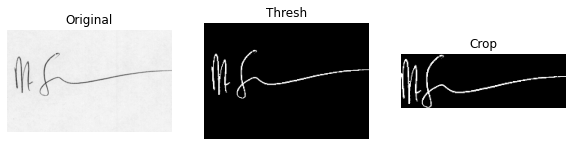

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10, 10))
ax1.imshow(img, cmap = 'gray')
ax2.imshow(imgTresh, cmap = 'gray')
ax3.imshow(imgThreshCrop, cmap = 'gray')
ax1.set_title('Original')
ax1.axis('off')
ax2.set_title('Thresh')
ax2.axis('off')
ax3.set_title('Crop')
ax3.axis('off')

In [9]:
print(len(cv_originals))
orig_lengths = [len(x) for x in cv_originals]
print(orig_lengths)

55
[24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24]


In [10]:
orig_train, orig_val, orig_test = cv_originals[:45], cv_originals[45:50], cv_originals[50:]
forg_train, forg_val, forg_test = cv_forgeries[:45], cv_forgeries[45:50], cv_forgeries[50:]

In [11]:
def generate_batch(orig_groups, forg_groups, batch_size = 128):
    '''Function to generate a batch of data with batch_size number of data points
    Half of the data points will be Genuine-Genuine pairs and half will be Genuine-Forged pairs'''
    while True:
        orig_pairs = []
        forg_pairs = []
        gen_gen_labels = []
        gen_for_labels = []
        all_pairs = []
        all_labels = []
        
        # Here we create pairs of Genuine-Genuine image names and Genuine-Forged image names
        # For every person we have 24 genuine signatures, hence we have 
        # 24 choose 2 = 276 Genuine-Genuine image pairs for one person.
        # To make Genuine-Forged pairs, we pair every Genuine signature of a person
        # with 12 randomly sampled Forged signatures of the same person.
        # Thus we make 24 * 12 = 300 Genuine-Forged image pairs for one person.
        # In all we have 120 person's data in the training data.
        # Total no. of Genuine-Genuine pairs = 120 * 276 = 33120
        # Total number of Genuine-Forged pairs = 120 * 300 = 36000
        # Total no. of data points = 33120 + 36000 = 69120
        for orig, forg in zip(orig_groups, forg_groups):
            orig_pairs.extend(list(itertools.combinations(orig, 2)))
            for i in range(len(forg)):
                forg_pairs.extend(list(itertools.product(orig[i:i+1], random.sample(forg, 12))))
        
        # Label for Genuine-Genuine pairs is 1
        # Label for Genuine-Forged pairs is 0
        gen_gen_labels = [1]*len(orig_pairs)
        gen_for_labels = [0]*len(forg_pairs)
        
        # Concatenate all the pairs together along with their labels and shuffle them
        all_pairs = orig_pairs + forg_pairs
        all_labels = gen_gen_labels + gen_for_labels
        del orig_pairs, forg_pairs, gen_gen_labels, gen_for_labels
        all_pairs, all_labels = shuffle(all_pairs, all_labels)
        
        # Note the lists above contain only the image names and
        # actual images are loaded and yielded below in batches
        # Below we prepare a batch of data points and yield the batch
        # In each batch we load "batch_size" number of image pairs
        # These images are then removed from the original set so that
        # they are not added again in the next batch.
            
        k = 0
        pairs=[np.zeros((batch_size, img_h, img_w, 1)) for i in range(2)]
        targets=np.zeros((batch_size,))
        for ix, pair in enumerate(all_pairs):
            img1 = cv2.imread(pair[0], 0)
            img2 = cv2.imread(pair[1], 0)
            # img1 = cv2.resize(img1, (img_w, img_h))
            # img2 = cv2.resize(img2, (img_w, img_h))

            img1 = thresholding(img1)
            img2 = thresholding(img2)

            img1 = crop(img1,10)
            img2 = crop(img2,10)

            img1 = cv2.resize(img1, (img_w, img_h))
            img2 = cv2.resize(img2, (img_w, img_h))

            img1 = np.array(img1, dtype = np.float64)
            img2 = np.array(img2, dtype = np.float64)
            img1 /= 255
            img2 /= 255
            img1 = img1[..., np.newaxis]
            img2 = img2[..., np.newaxis]
            pairs[0][k, :, :, :] = img1
            pairs[1][k, :, :, :] = img2
            targets[k] = all_labels[ix]
            k += 1
            if k == batch_size:
                yield pairs, targets
                k = 0
                pairs=[np.zeros((batch_size, img_h, img_w, 1)) for i in range(2)]
                targets=np.zeros((batch_size,))


In [12]:
def visualize_sample_signature():
    '''Function to randomly select a signature from train set and
    print two genuine copies and one forged copy'''
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10, 10))
    k = np.random.randint(len(orig_train))
    orig_img_names = random.sample(orig_train[k], 2)
    forg_img_name = random.sample(forg_train[k], 1)
    orig_img1 = cv2.imread(orig_img_names[0], 0)
    orig_img2 = cv2.imread(orig_img_names[1], 0)
    forg_img = cv2.imread(forg_img_name[0], 0)

    orig_img1 = thresholding(orig_img1)
    orig_img2 = thresholding(orig_img2)
    forg_img = thresholding(forg_img)

    orig_img2 = crop(orig_img2,10)
    orig_img1 = crop(orig_img1,10)
    forg_img = crop(forg_img,10)

    orig_img1 = cv2.resize(orig_img1, (img_w, img_h))
    orig_img2 = cv2.resize(orig_img2, (img_w, img_h))
    forg_img = cv2.resize(forg_img, (img_w, img_h))

    ax1.imshow(orig_img1, cmap = 'gray')
    ax2.imshow(orig_img2, cmap = 'gray')
    ax3.imshow(forg_img, cmap = 'gray')

    ax1.set_title('Genuine Copy')
    ax1.axis('off')
    ax2.set_title('Genuine Copy')
    ax2.axis('off')
    ax3.set_title('Forged Copy')
    ax3.axis('off')

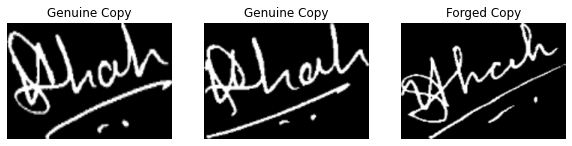

In [13]:
visualize_sample_signature()

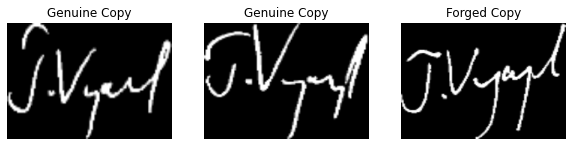

In [16]:
visualize_sample_signature()

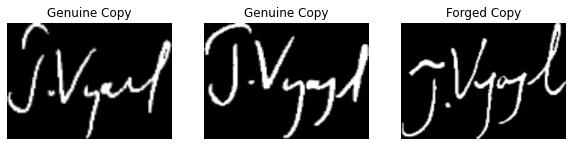

In [17]:
visualize_sample_signature()

In [14]:
def euclidean_distance(vects):
    '''Compute Euclidean Distance between two vectors'''
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))

# Bu fonksiyonu modelimizin üreteceği çıktının boyutunu belirlemek için kullanacağız.
def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [15]:
def contrastive_loss(y_true, y_pred):
    y_true = tf.cast(y_true, y_pred.dtype)
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0) ))

In [16]:
def Signet(input_shape):

    seq = Sequential()
    seq.add(Conv2D(96, kernel_size=(11, 11), activation='relu', name='conv1_1', strides=4, input_shape= input_shape, kernel_initializer='glorot_uniform'))
    seq.add(BatchNormalization(epsilon=1e-06, axis=1, momentum=0.9))
    seq.add(MaxPooling2D((3,3), strides=(2, 2)))    
    seq.add(ZeroPadding2D((2, 2)))
    
    seq.add(Conv2D(256, kernel_size=(5, 5), activation='relu', name='conv2_1', strides=1, kernel_initializer='glorot_uniform'))
    seq.add(BatchNormalization(epsilon=1e-06, axis=1, momentum=0.9))
    seq.add(MaxPooling2D((3,3), strides=(2, 2)))
    seq.add(Dropout(0.3))
    seq.add(ZeroPadding2D((1, 1)))
    
    seq.add(Conv2D(384, kernel_size=(3, 3), activation='relu', name='conv3_1', strides=1, kernel_initializer='glorot_uniform'))
    seq.add(ZeroPadding2D((1, 1)))
    
    seq.add(Conv2D(256, kernel_size=(3, 3), activation='relu', name='conv3_2', strides=1, kernel_initializer='glorot_uniform'))    
    seq.add(MaxPooling2D((3,3), strides=(2, 2)))
    seq.add(Dropout(0.3))
    seq.add(Flatten(name='flatten'))
    seq.add(Dense(1024, kernel_regularizer=l2(0.0005), activation='relu', kernel_initializer='glorot_uniform'))
    seq.add(Dropout(0.5))
    
    seq.add(Dense(128, kernel_regularizer=l2(0.0005), activation='relu', kernel_initializer='glorot_uniform'))
    
    return seq

In [17]:
input_shape=(img_h, img_w, 1)

In [18]:
# network definition
base_network = Signet(input_shape)

input_a = Input(shape=(input_shape))
input_b = Input(shape=(input_shape))

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

# Compute the Euclidean distance between the two vectors in the latent space
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model([input_a, input_b], distance)

In [19]:
rms = tf.keras.optimizers.RMSprop(learning_rate=1e-4, rho=0.9, epsilon=1e-08)
model.compile(loss=contrastive_loss, optimizer=rms)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 155, 220, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 155, 220, 1  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 128)          6461084     ['input_1[0][0]',                
                                                                  'input_2[0][0]']            

In [20]:
results = model.fit(generate_batch(orig_train, forg_train, 128),
                              steps_per_epoch = 60,
                              epochs = 10,
                              validation_data = generate_batch(orig_val, forg_val, 128),
                              validation_steps = 30)

Epoch 1/10
60/60 [==============================] - 1375s 23s/step - loss: 8.8531 - val_loss: 1.4276
Epoch 2/10
60/60 [==============================] - 1355s 23s/step - loss: 1.1867 - val_loss: 1.3644
Epoch 3/10
60/60 [==============================] - 1347s 23s/step - loss: 1.1218 - val_loss: 1.2816
Epoch 4/10
60/60 [==============================] - 1361s 23s/step - loss: 1.0023 - val_loss: 1.1191
Epoch 5/10
60/60 [==============================] - 1353s 23s/step - loss: 0.8588 - val_loss: 0.9816
Epoch 6/10
60/60 [==============================] - 1357s 23s/step - loss: 0.7368 - val_loss: 0.8318
Epoch 7/10
60/60 [==============================] - 1363s 23s/step - loss: 0.6278 - val_loss: 0.7329
Epoch 8/10
60/60 [==============================] - 1363s 23s/step - loss: 0.5495 - val_loss: 0.6018
Epoch 9/10
60/60 [==============================] - 1348s 23s/step - loss: 0.4856 - val_loss: 0.6010
Epoch 10/10
60/60 [==============================] - 1348s 23s/step - loss: 0.4349 - val_lo

In [21]:
# Function to compute accuracy
def compute_accuracy_roc(predictions, labels):
    '''Compute ROC accuracy with a range of thresholds on distances.
    '''
    dmax = np.max(predictions)
    dmin = np.min(predictions)
    nsame = np.sum(labels == 1)
    ndiff = np.sum(labels == 0)
   
    step = 0.01
    max_acc = 0
    best_thresh = -1
   
    for d in np.arange(dmin, dmax+step, step):
        idx1 = predictions.ravel() <= d
        idx2 = predictions.ravel() > d
     
        tpr = float(np.sum(labels[idx1] == 1)) / nsame       
        tnr = float(np.sum(labels[idx2] == 0)) / ndiff
        acc = 0.5 * (tpr + tnr)       
       
        if (acc > max_acc):
            max_acc, best_thresh, best_tpr, best_tnr = acc, d, tpr, tnr
           
    return max_acc, best_thresh, best_tpr, best_tnr

In [ ]:

# Loading the best weights to the model
# model.load_weights('./Weights.h5')


In [22]:
test_gen = generate_batch(orig_test, forg_test, 1) 
pred, tr_y = [], []
for i, j in enumerate(range(100)):
    (img1, img2), label = next(test_gen)
    tr_y.append(label)
    pred.append(model.predict([img1, img2])[0][0])

In [23]:
# Accuracy, Threshold, TPR & TNR (Best) 
tr_acc, threshold, best_tpr, best_tnr = compute_accuracy_roc(np.array(pred), np.array(tr_y))
print("Accuracy: ", tr_acc, "\nThreshold: ", threshold, "\nTPR: ", best_tpr,"\nTNR: ", best_tnr)

Accuracy:  0.7435064935064934 
Threshold:  0.24481370046734813 
TPR:  0.7142857142857143 
TNR:  0.7727272727272727


In [24]:
# Predict distance score and classify test images as Genuine or Forged
def predict_score():
    test_point, test_label = next(test_gen)
    img1, img2 = test_point[0], test_point[1]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 10))
    ax1.imshow(np.squeeze(img1), cmap='gray')
    ax2.imshow(np.squeeze(img2), cmap='gray')
    ax1.set_title('Genuine')
    if test_label == 1:
        ax2.set_title('Genuine')
    else:
        ax2.set_title('Forged')
    ax1.axis('off')
    ax2.axis('off')
    plt.show()
    result = model.predict([img1, img2])
    diff = result[0][0]
    print("Difference Score = ", diff)
    if diff > threshold:
        print("Its a Forged Signature")
    else:
        print("Its a Genuine Signature")

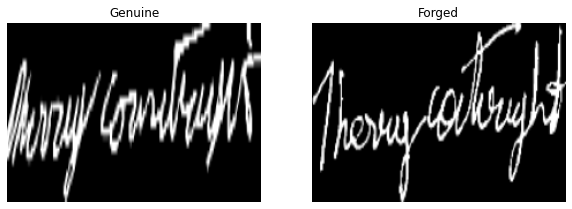

Difference Score =  0.29407072
Its a Forged Signature


In [36]:
predict_score()

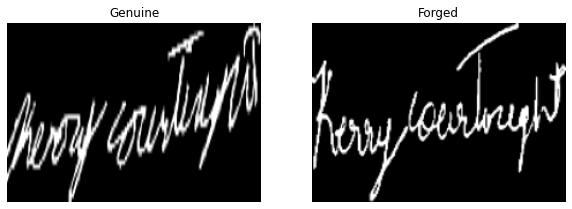

Difference Score =  0.24585481
Its a Forged Signature


In [37]:
predict_score()

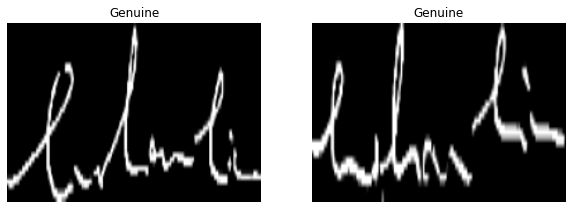

Difference Score =  0.4221062
Its a Forged Signature


In [27]:
predict_score()

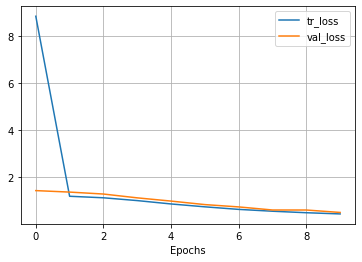

In [38]:
# Loss plot
plt.plot(range(len(results.history['loss'])), results.history['loss'], label="tr_loss")
plt.plot(range(len(results.history['val_loss'])), results.history['val_loss'], label="val_loss")
# plt.plot(range(len(results.history[ 'learning_rate'])), results.history['lr'], label="learning rate")

plt.xlabel("Epochs")
plt.legend()
plt.grid(True)
plt.savefig("lossplot.png",dpi=300)
plt.show()

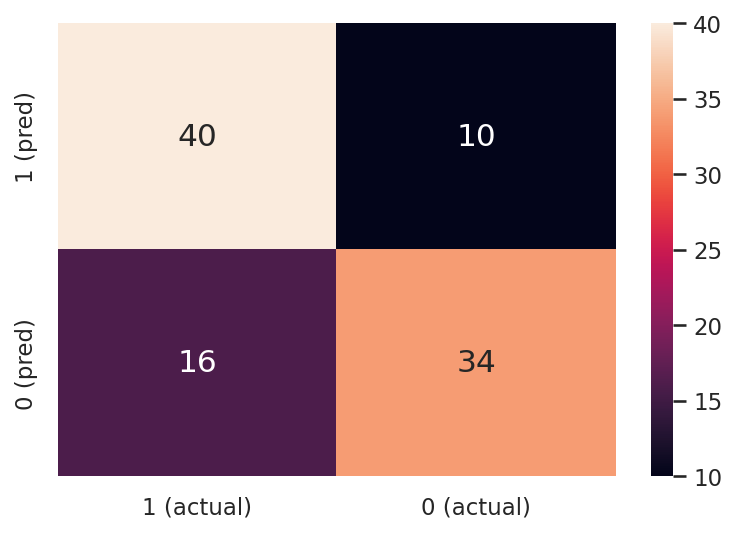

In [39]:
# Confusion Matrix
# Gen-Forged pair (0) 
# Gen-Gen pair (1) 

orig_labels = np.array(tr_y)
pred_labels = np.array(pred)
TP, TN, FP, FN = 0, 0, 0, 0

for i, j in zip(orig_labels, pred_labels):
  if i[0]==0 and j>=threshold:
    TN+=1
  if i[0]==0 and j<threshold:
    FP+=1
  if i[0]==1 and j<threshold:
    TP+=1
  if i[0]==1 and j>=threshold:
    FN+=1

array = [[TP,FP],
         [FN,TN]]

df_cm = pd.DataFrame(array, range(2), range(2))
plt.figure(dpi=150)
sn.set(font_scale=1)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 15}, fmt='g', xticklabels=['1 (actual)','0 (actual)'], yticklabels=['1 (pred)','0 (pred)'])
plt.savefig("confmat.png",dpi=300)
plt.show()

In [ ]:
import visualkeras
visualkeras.layered_view(base_network, legend=True, scale_xy=4, scale_z=0.05, to_file='network_struct.png')